<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/nlp/NLP_NER_and_POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
bouweceunen_climate_fever_dataset_path = kagglehub.dataset_download('bouweceunen/climate-fever-dataset')

print('Data source import complete.')


Data source import complete.


# Introduction

In this Jupyter notebook, we will be applying various Natural Language Processing (NLP) techniques such as Named Entity Recognition (NER) and Part-of-Speech (POS) tagging. The primary focus of our analysis will be the Climate Fever dataset, which comprises articles related to climate change. Our objective is to extract named entities from these articles and assign POS tags to different parts of speech in the text. This exercise will help us understand the underlying structure and semantics of the text, thereby enabling us to extract meaningful insights from it.

### Dataset Selection

The dataset we will be working with is called the Climate claim dataset. It adopts the FEVER methodology and consists of 1535 real-world claims regarding climate change collected from the internet. Each claim is accompanied by five manually annotated evidence sentences retrieved from the English Wikipedia. These sentences either support, refute, or do not provide enough information to validate the claim, resulting in a total of 7675 claim-evidence pairs. The dataset features challenging claims that relate multiple facets and disputed cases of claims where both supporting and refuting evidence are present.

### Methodology

In this notebook we used the following methodology
1. Exploration
2. Cleanup
3. Text Processing
4. Conclustions

# Exploration

- Explore the dataset to understand its structure, format, and attributes.
- Identify the specific column(s) or attribute(s) that contain the textual data you will be working with.

#### Loading the Climate Dataset

In [2]:
import pandas as pd
import requests
import re
import os
import sys
import numpy as np
import gzip
import json
import torch
import zipfile

#### Extract the Zip file

In [3]:
claims_df = pd.read_csv('/content/climate-fever.csv')

In [4]:
claims_df.head()

,claim_id,claim,claim_label,evidences/0/evidence_id,evidences/0/evidence_label,evidences/0/article,evidences/0/evidence,evidences/0/entropy,evidences/0/votes/0,evidences/0/votes/1,...,evidences/4/evidence_id,evidences/4/evidence_label,evidences/4/article,evidences/4/evidence,evidences/4/entropy,evidences/4/votes/0,evidences/4/votes/1,evidences/4/votes/2,evidences/4/votes/3,evidences/4/votes/4
0,0,Global warming is driving polar bears toward e...,SUPPORTS,Extinction risk from global warming:170,NOT_ENOUGH_INFO,Extinction risk from global warming,"""Recent Research Shows Human Activity Driving ...",0.693147,SUPPORTS,NOT_ENOUGH_INFO,...,Polar bear:1328,NOT_ENOUGH_INFO,Polar bear,"""Bear hunting caught in global warming debate"".",0.693147,SUPPORTS,NOT_ENOUGH_INFO,NaN,NaN,NaN
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,Famine:386,SUPPORTS,Famine,The current consensus of the scientific commun...,0.000000,SUPPORTS,SUPPORTS,...,Winter:5,NOT_ENOUGH_INFO,Winter,"In many regions, winter is associated with sno...",0.693147,REFUTES,NOT_ENOUGH_INFO,NaN,NaN,NaN
2,6,The polar bear population has been growing.,REFUTES,Polar bear:1332,NOT_ENOUGH_INFO,Polar bear,"""Ask the experts: Are polar bear populations i...",0.693147,NOT_ENOUGH_INFO,REFUTES,...,Polar bear:61,REFUTES,Polar bear,Of the 19 recognized polar bear subpopulations...,0.000000,REFUTES,REFUTES,NaN,NaN,NaN
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,Atmosphere of Mars:131,NOT_ENOUGH_INFO,Atmosphere of Mars,CO2 in the mesosphere acts as a cooling agent ...,0.693147,NOT_ENOUGH_INFO,SUPPORTS,...,Carbon dioxide:191,NOT_ENOUGH_INFO,Carbon dioxide,"Less energy reaches the upper atmosphere, whic...",0.000000,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,NaN,NaN,NaN
4,10,Human additions of CO2 are in the margin of er...,REFUTES,Carbon dioxide in Earth's atmosphere:140,NOT_ENOUGH_INFO,Carbon dioxide in Earth's atmosphere,While CO 2 absorption and release is always ha...,0.693147,NOT_ENOUGH_INFO,REFUTES,...,Sea:226,REFUTES,Sea,"More recently, anthropogenic activities have s...",0.000000,REFUTES,REFUTES,NaN,NaN,NaN


### Print a random row

In [5]:
# Get a random row from the dataframe
random_row = claims_df.sample(n=1)

# Convert the row to JSON format
random_row_json = random_row.to_json(orient='records')

# Parse the JSON string to a python dict
random_row_dict = json.loads(random_row_json)

# Print the dict in pretty format
print(json.dumps(random_row_dict[0], indent=4))

{
    "claim_id": 2679,
    "claim": "\"The solubility of carbon dioxide in water is listed in the Handbook of Chemistry and Physics as a declining function of temperature. ...",
    "claim_label": "NOT_ENOUGH_INFO",
    "evidences/0/evidence_id": "Carbon dioxide:220",
    "evidences/0/evidence_label": "NOT_ENOUGH_INFO",
    "evidences/0/article": "Carbon dioxide",
    "evidences/0/evidence": "Also, the Intergovernmental Panel on Climate Change (IPCC) writes in their Climate Change 2007: Synthesis Report: \"The uptake of anthropogenic carbon since 1750 has led to the ocean becoming more acidic with an average decrease in pH of 0.1 units.",
    "evidences/0/entropy": 0.6365141683,
    "evidences/0/votes/0": "SUPPORTS",
    "evidences/0/votes/1": "NOT_ENOUGH_INFO",
    "evidences/0/votes/2": "NOT_ENOUGH_INFO",
    "evidences/0/votes/3": null,
    "evidences/0/votes/4": null,
    "evidences/1/evidence_id": "Henry's law:84",
    "evidences/1/evidence_label": "NOT_ENOUGH_INFO",
    "evidenc

**result**
- The dataset includes several fields such as `claim_id` (a unique identifier for each claim), `claim` (the text of the claim), `claim_label` (the overall label assigned to the claim based on majority vote on evidences), `evidences` (the top five evidence sentences), `evidence_id` (a unique identifier for each evidence), `evidence_label` (a micro-verdict label), `article` (the title of the source article or Wikipedia page), `evidence` (the evidence sentence), `entropy` (a measure reflecting the uncertainty of votes), and `votes` (an array containing individual votes).
- Since the goal of the exercise is to extract named entities and assign POS tags to different parts of speech in the text, we will randomly select one of text fields `evidence/3` for our NEP and POS tagging analsys

In [6]:
# Extract only the fields related to "evidences/0" from the dictionary
evidence_0_dict = {k: v for k, v in random_row_dict[0].items() if 'evidences/3' in k}

# Print the extracted dictionary in pretty format
print(json.dumps(evidence_0_dict, indent=4))

{
    "evidences/3/evidence_id": "Solubility:58",
    "evidences/3/evidence_label": "NOT_ENOUGH_INFO",
    "evidences/3/article": "Solubility",
    "evidences/3/evidence": "In liquid water at high temperatures, (e.g.",
    "evidences/3/entropy": 0.0,
    "evidences/3/votes/0": "NOT_ENOUGH_INFO",
    "evidences/3/votes/1": "NOT_ENOUGH_INFO",
    "evidences/3/votes/2": "NOT_ENOUGH_INFO",
    "evidences/3/votes/3": null,
    "evidences/3/votes/4": null
}


In [7]:
evidences_0=claims_df["evidences/3/evidence"]
evidences_0[:20]

,evidences/3/evidence
0,"Rising global temperatures, caused by the gree..."
1,The manifestation of the meteorological winter...
2,In two areas where harvest levels have been in...
3,The greenhouse effect is a process by which th...
4,Ocean acidification is the ongoing decrease in...
5,"At present, the primary source of CO 2 emissio..."
6,Other environmental pressures on the reef and ...
7,"The present, unprecedented scale and speed of ..."
8,Because its atmosphere consists mainly of CO 2...
9,Data collected by the Commonwealth Scientific ...


**result:**  
- On printing the last 20 rows of the dataframe, we see that the text fields are relatively clean but contain Punctuations, stop words, ASCII characters, dates etc.

## Text Length Analysis

Calculate the length of each review and analyze the distribution of lengths to garner insights into the average length of claims, the range of lengths, etc.

count    1535.000000
mean       27.307492
std        14.283105
min         3.000000
25%        18.000000
50%        25.000000
75%        33.000000
max       131.000000
Name: word_count, dtype: float64


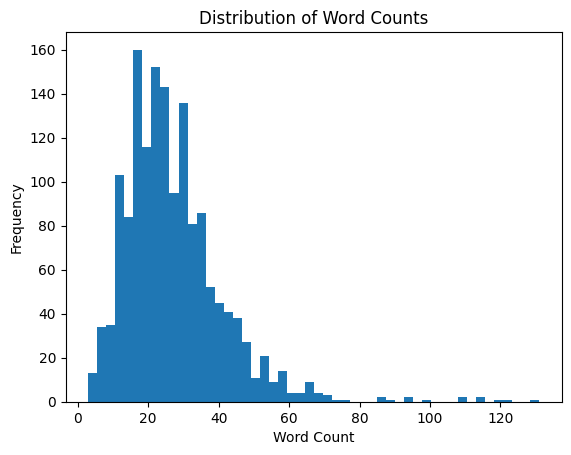

In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Apply the function to the 'evidences/0/evidence' column
claims_df['word_count'] = evidences_0.apply(word_count)

# Print out a summary of the word count statistics
print(claims_df['word_count'].describe())

# Plot a histogram of the word counts
plt.hist(claims_df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**Result**
- The distribution shows the word count ranges from 3 to 131, with an average of 27.3, a median of 25, and a standard deviation of 14.28.

#### Filterting out claims that have < 100 words

In [9]:
# Filterting out claims that have < 100 words
claims_df = claims_df[evidences_0.apply(lambda x: len(x.split()) < 100)]

/tmp/ipython-input-10-2501158303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_df['word_count'] = evidences_0.apply(word_count)


count    1528.000000
mean       26.896597
std        12.948279
min         3.000000
25%        18.000000
50%        25.000000
75%        33.000000
max        99.000000
Name: word_count, dtype: float64


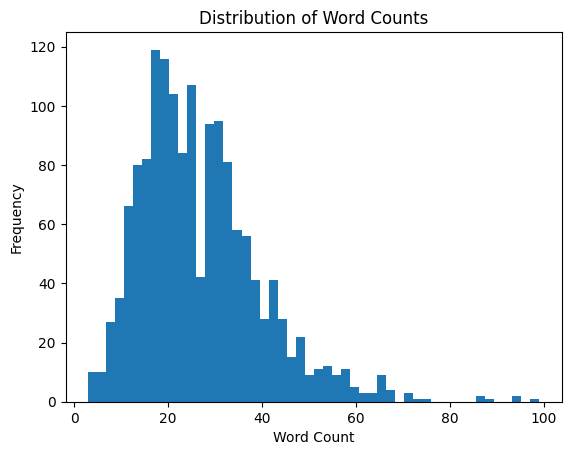

In [10]:
# Checking the new distribution
claims_df['word_count'] = evidences_0.apply(word_count)

# Print out a summary of the word count statistics
print(claims_df['word_count'].describe())

# Plot a histogram of the word counts
plt.hist(claims_df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Word Frequency Analysis

We counted the frequency of each word in the claims. This helped in identifying the most common words, which might have been important features for machine learning models. We reviewed the frequency later after we reviewed stop words, applied stemming, lemmatization.

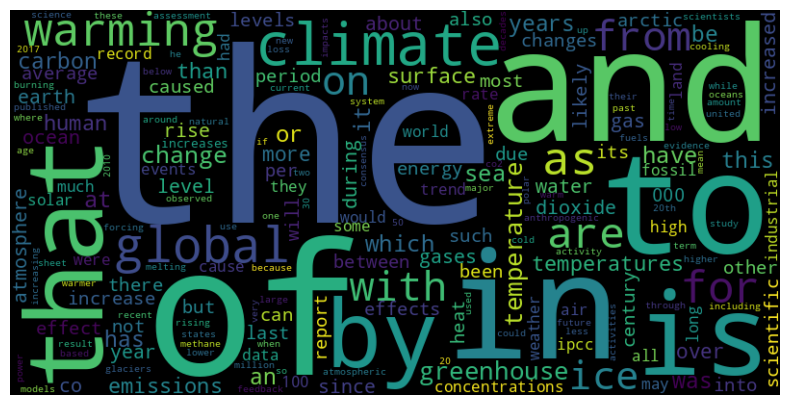

In [11]:
import torch
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the claims
X = vectorizer.fit_transform(evidences_0)

# Convert the matrix to a PyTorch tensor
X_tensor = torch.from_numpy(X.toarray())

# Calculate word frequencies
word_freq = torch.sum(X_tensor, dim=0)

# Convert tensor back to numpy array for visualization
word_freq_np = word_freq.numpy()

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame(word_freq_np, index=vectorizer.get_feature_names_out(), columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**result**

- Our first pass at WordFrequency analsys, we found that the most common word were stop words, specifically `the` is the most common word followed by `and` and `of`. This will be cleaned up after the removal of stop words

# Cleanup

## Contractions

We used the [contractions](https://github.com/kootenpv/contractions) package to resolve contractions and  (and slang), `examples:you're -> you are`



In [12]:
!pip install contractions

In [13]:
import contractions
claims_df["text_clean"] = evidences_0.apply(lambda x: contractions.fix(x))
evidences_0[9]

'Data collected by the Commonwealth Scientific and Industrial Research Organisation (CSIRO) in Australia show the current global mean sea level trend to be 3.2\xa0mm (0.13\xa0in) per year, a doubling of the rate during the 20th century.'

## Remove URLs
Remove URL from text

In [14]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)
claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: remove_URL(x))
claims_df.text_clean[9]

'Data collected by the Commonwealth Scientific and Industrial Research Organisation (CSIRO) in Australia show the current global mean sea level trend to be 3.2\xa0mm (0.13\xa0in) per year, a doubling of the rate during the 20th century.'

## Remove Non-ASCI Characters

In [15]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable])

claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: remove_non_ascii(x))
claims_df.text_clean[9]

'Data collected by the Commonwealth Scientific and Industrial Research Organisation (CSIRO) in Australia show the current global mean sea level trend to be 3.2mm (0.13in) per year, a doubling of the rate during the 20th century.'

## Make characters lowercase

In [16]:
claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: x.lower())
claims_df.text_clean[9]

'data collected by the commonwealth scientific and industrial research organisation (csiro) in australia show the current global mean sea level trend to be 3.2mm (0.13in) per year, a doubling of the rate during the 20th century.'

## Remove html

In [17]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: remove_html(x))
claims_df.text_clean[9]

'data collected by the commonwealth scientific and industrial research organisation (csiro) in australia show the current global mean sea level trend to be 3.2mm (0.13in) per year, a doubling of the rate during the 20th century.'

## Remove symbols

In [18]:
def remove_symbols(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: remove_symbols(x))
claims_df.text_clean[9]

'data collected by the commonwealth scientific and industrial research organisation (csiro) in australia show the current global mean sea level trend to be 3.2mm (0.13in) per year, a doubling of the rate during the 20th century.'

## Remove Special characters

In [19]:
def remove_special_chars(text):
    """
        Remove special characters (\n, \, ', "") in sample text
    """
    # Replace \n, \ and ' with empty string
    text = text.replace('\n', '').replace('\\', '').replace('\'', '').replace('\"', '')
    return text

# Assuming claims_df is a DataFrame with a column "text_clean" containing text data
claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: remove_special_chars(x))
print(claims_df.text_clean[9])

data collected by the commonwealth scientific and industrial research organisation (csiro) in australia show the current global mean sea level trend to be 3.2mm (0.13in) per year, a doubling of the rate during the 20th century.


### Remove punctuations

In [20]:
import re
def remove_punct(text):

    # Replace punctuation with space, except for decimal points in numerical values
    return re.sub(r'(?:(?<!\d)[.,;()]|[.,;()](?!\d))', '', text)

# Apply the function to the dataframe
claims_df["text_clean"] = claims_df["text_clean"].apply(lambda x: remove_punct(x))

# Print the 10th row of the cleaned text column
print(claims_df.text_clean[9])

data collected by the commonwealth scientific and industrial research organisation csiro in australia show the current global mean sea level trend to be 3.2mm 0.13in per year a doubling of the rate during the 20th century


**result**
- In removing punctuations, we needed to be carefull not to remove punctuations in between numbers in order to preseve the information in text, doing so would have caused values such as `3.2mm` -> `32mm` or `0.13in` -> `013in` which would have changed the meaning of the text

# Text Preprocessing
- Perform tokenization on the textual data. Split the text into individual tokens (words, punctuation, or other meaningful units) using an appropriate tokenization technique or library.
- Remove stop words from the tokenized text. Remove common words (e.g., "the," "is," "and") that do not carry significant meaning using a standard stop word list or library.
- Apply stemming to the tokens. Reduce each word to its base or root form using a suitable stemming algorithm or library.
- Implement lemmatization on the tokens. Transform each word into its canonical or dictionary form using a reliable lemmatization technique or library.


## Tokenization

Tokenization is the process of breaking down text into smaller parts called tokens which help in understanding the context or developing the model for NLP (Natural Language Processing). The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words.

For instance, consider the text "The quick brown fox jumps over the lazy dog". In tokenization, this sentence is broken down into individual words: 'The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'.

In [22]:
import nltk
from nltk.tokenize import word_tokenize

claims_df['tokenized'] = claims_df['text_clean'].apply(word_tokenize)
claims_df.tokenized[9]

['data',
 'collected',
 'by',
 'the',
 'commonwealth',
 'scientific',
 'and',
 'industrial',
 'research',
 'organisation',
 'csiro',
 'in',
 'australia',
 'show',
 'the',
 'current',
 'global',
 'mean',
 'sea',
 'level',
 'trend',
 'to',
 'be',
 '3.2mm',
 '0.13in',
 'per',
 'year',
 'a',
 'doubling',
 'of',
 'the',
 'rate',
 'during',
 'the',
 '20th',
 'century']

In [23]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**result**
- The `word_tokenize` does not catch `20th`, `0.13in` or `3.2mm`. This can be treated seperatly using `pint` library for Unit Converstion and `inflect` for word expansion. For NLP for most nlp downstream tasks, these definitions of tokens are fine and can be left as is

## Remove stop words

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# Removing stopwords.
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
claims_df['stopwords_removed'] = claims_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
claims_df.stopwords_removed[9]

['data',
 'collected',
 'commonwealth',
 'scientific',
 'industrial',
 'research',
 'organisation',
 'csiro',
 'australia',
 'show',
 'current',
 'global',
 'mean',
 'sea',
 'level',
 'trend',
 '3.2mm',
 '0.13in',
 'per',
 'year',
 'doubling',
 'rate',
 '20th',
 'century']

count    1528.000000
mean       16.580497
std         8.036105
min         3.000000
25%        11.000000
50%        15.000000
75%        21.000000
max        67.000000
Name: word_count, dtype: float64


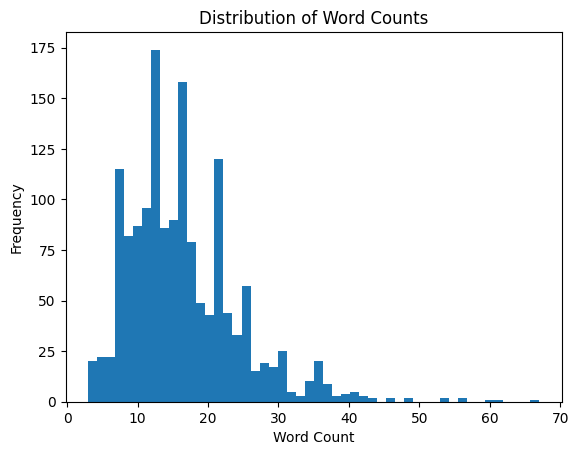

In [27]:
# Apply the function to the 'stopwords_removed' column
claims_df['word_count'] = claims_df['stopwords_removed'].apply(' '.join).apply(word_count)

# Print out a summary of the word count statistics
print(claims_df['word_count'].describe())

# Plot a histogram of the word counts
plt.hist(claims_df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**result**
- After removing the stop words, maximum length of review goes from 89 to 54 words.

## Stemming

Stemming is a technique used to extract the base form of the words by removing affixes from them. It is just like cutting down the branches of a tree to its stems. For example, the stem of the words eating, eats, eaten is eat.   
Reference: https://www.tutorialspoint.com/natural_language_toolkit/natural_language_toolkit_stemming_lemmatization.htm

The Porter, Snowball, and Lancaster stemming algorithms in NLTK differ in their aggressiveness and accuracy. Porter is the gentlest and oldest, mainly removing common word endings. Snowball, or Porter2, is more aggressive and accurate than Porter. Lancaster is the most aggressive, allowing custom rules but may transform words excessively.

In [28]:
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems

claims_df['snowball_stemmer'] = claims_df['stopwords_removed'].apply(lambda x: snowball_stemmer(x))
claims_df.snowball_stemmer[9]

['data',
 'collect',
 'commonwealth',
 'scientif',
 'industri',
 'research',
 'organis',
 'csiro',
 'australia',
 'show',
 'current',
 'global',
 'mean',
 'sea',
 'level',
 'trend',
 '3.2mm',
 '0.13in',
 'per',
 'year',
 'doubl',
 'rate',
 '20th',
 'centuri']

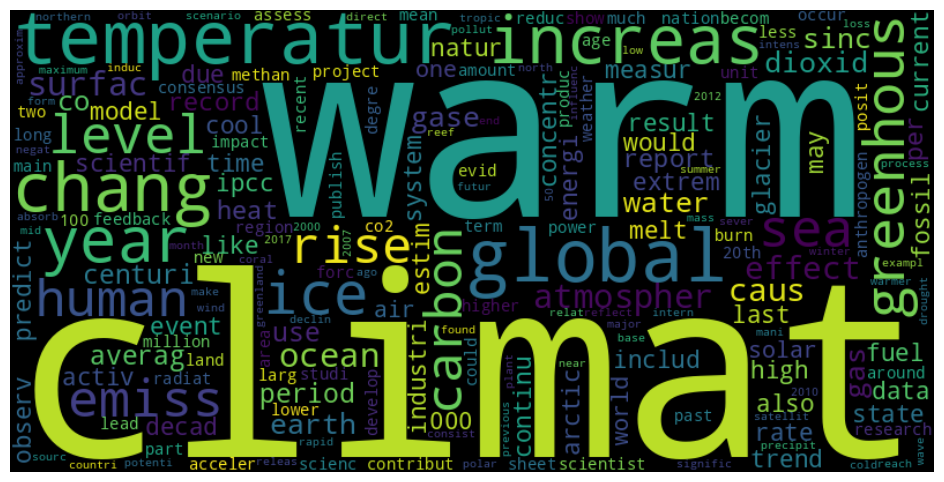

In [29]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the claims
X = vectorizer.fit_transform(claims_df['snowball_stemmer'].apply(' '.join))

# Convert the matrix to a PyTorch tensor
X_tensor = torch.from_numpy(X.toarray())

# Calculate word frequencies
word_freq = torch.sum(X_tensor, dim=0)

# Convert tensor back to numpy array for visualization
word_freq_np = word_freq.numpy()

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame(word_freq_np, index=vectorizer.get_feature_names_out(), columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**result**
- Using snowball stemmer to removing affixes from them words to form stem words. Resulted in words like `climat` and `tempratur` that were not true root words

## Lemmatization

The output we will get after lemmatization is called ‘lemma’, which is a root word rather than root stem, the output of stemming. After lemmatization, we will be getting a valid word that means the same thing.

Reference: https://www.tutorialspoint.com/natural_language_toolkit/natural_language_toolkit_stemming_lemmatization.htm

We conducted lemmatization with and without POS tagging

In [30]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    """
        Lemmatize words in list of tokenized words
    """
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(i) for i in text]
    return lemmas

claims_df['lemmatized_no_pos'] = claims_df['stopwords_removed'].apply(lambda x: lemmatize_text(x))
claims_df.lemmatized_no_pos[9]

['data',
 'collected',
 'commonwealth',
 'scientific',
 'industrial',
 'research',
 'organisation',
 'csiro',
 'australia',
 'show',
 'current',
 'global',
 'mean',
 'sea',
 'level',
 'trend',
 '3.2mm',
 '0.13in',
 'per',
 'year',
 'doubling',
 'rate',
 '20th',
 'century']

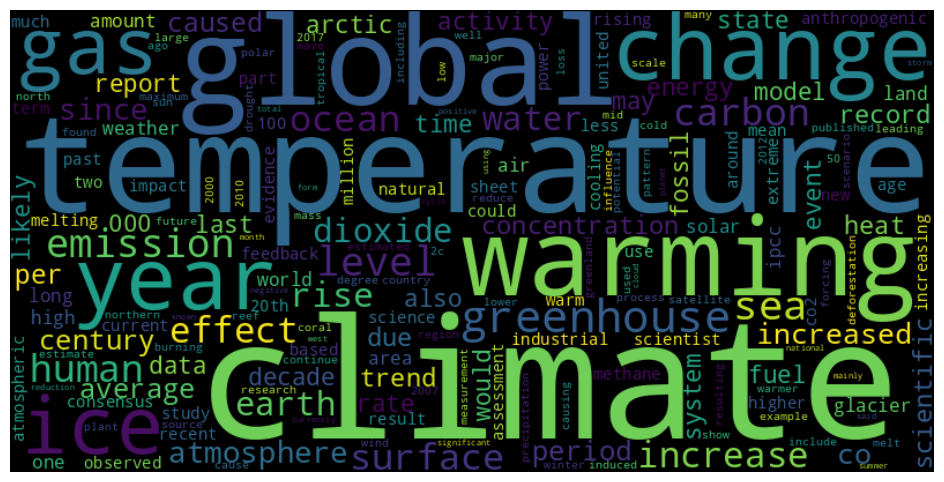

In [33]:

# Fit and transform the claims
X = vectorizer.fit_transform(claims_df['lemmatized_no_pos'].apply(' '.join))

# Convert the matrix to a PyTorch tensor
X_tensor = torch.from_numpy(X.toarray())

# Calculate word frequencies
word_freq = torch.sum(X_tensor, dim=0)

# Convert tensor back to numpy array for visualization
word_freq_np = word_freq.numpy()

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame(word_freq_np, index=vectorizer.get_feature_names_out(), columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**result**  
- Using lemmatized resulted in root word that had a valid meaning. Cases where it did not correctly identify the root words such as `warming` rather than `warm` that was identified by stemming. We considered ways to increase the accuracy of lemmetization

### POS tagging

Part-of-Speech (POS) tagging is a natural language processing task that involves labeling each word in a text with its corresponding grammatical category or part of speech, such as noun, verb, adjective, adverb, etc.

In this section we will applied POS tagging using `WordNetLemmatizer`, then applied the `POS tagging` to the `claims_df['stopwords_removed']` columnn. We then used the resulting dataframe to find the lemma of the tokens, then compared the results with lemma results witout POS-tagging

In [34]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [35]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# A tagset is a list of part-of-speech tags. In NLTK, these tags mark semantic information about the words they are associated with.
# For example, the tag 'NN' stands for a singular noun, 'VB' stands for a verb in base form, etc.

# Perform POS tagging using NLTK to the 'claims_df["stopwords_removed"]' dataframe
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Apply POS tagging to the 'stopwords_removed' column and create a new column 'stopwords_removed_pos'
claims_df['stopwords_removed_pos'] = claims_df['stopwords_removed'].apply(lambda x: [(word, get_wordnet_pos(word)) for word in x])

In [36]:
claims_df.stopwords_removed_pos[9]

[('data', 'n'),
 ('collected', 'v'),
 ('commonwealth', 'n'),
 ('scientific', 'a'),
 ('industrial', 'a'),
 ('research', 'n'),
 ('organisation', 'n'),
 ('csiro', 'n'),
 ('australia', 'n'),
 ('show', 'n'),
 ('current', 'a'),
 ('global', 'a'),
 ('mean', 'n'),
 ('sea', 'n'),
 ('level', 'n'),
 ('trend', 'n'),
 ('3.2mm', 'n'),
 ('0.13in', 'n'),
 ('per', 'n'),
 ('year', 'n'),
 ('doubling', 'v'),
 ('rate', 'n'),
 ('20th', 'a'),
 ('century', 'n')]

On visualization of the function to visualize the distribution of POS-tags in the corpus

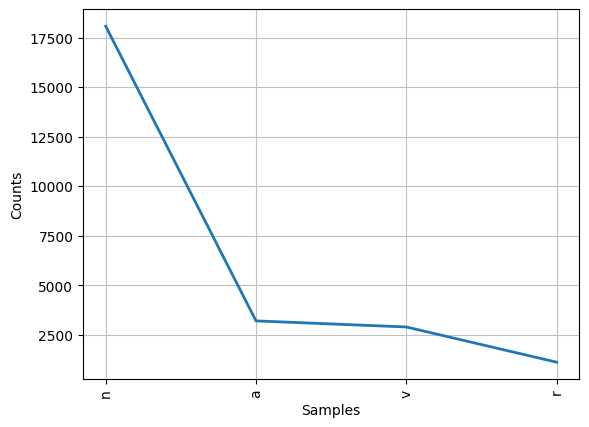

In [37]:
def visualize_pos_distribution(df):
    """Visualize the distribution of POS tags in the corpus"""
    pos_list = [pos for word, pos in df['stopwords_removed_pos'].sum()]
    pos_freq = nltk.FreqDist(pos_list)
    pos_freq.plot(20, cumulative=False)
    plt.show()

visualize_pos_distribution(claims_df)

**result**
- On the examination of the distribution of the POS-tags, we see that there is high distribution of nouns

In [38]:
### Lamatize with POS tagging
lemmatizer = WordNetLemmatizer()
def lemmatize_with_pos(token_pos):
    """Perform lemmatization using POS tag"""
    return [lemmatizer.lemmatize(word, pos) for word, pos in token_pos]

# Apply lemmatization function to the 'stopwords_removed_pos' column and create a new column 'lemmatize_pos'
claims_df['lemmatize_pos'] = claims_df['stopwords_removed_pos'].apply(lemmatize_with_pos)


### Difference between the lemmatized `with-POS-tagging` vs the lemmatized `withOUT-POS-tagging`

In [39]:
# Importing required libraries
from termcolor import colored

# Function to highlight differences between two lists
def highlight_diff(list1, list2):
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            list1[i] = colored(list1[i], 'red')
            list2[i] = colored(list2[i], 'red')
    return list1, list2

lemmatize_pos_diff = claims_df.lemmatize_pos[9].copy()

lemmatized_no_pos_diff = claims_df.lemmatized_no_pos[9].copy()

# Highlighting the differences
lemmatize_pos_diff, lemmatized_no_pos_diff = highlight_diff(lemmatize_pos_diff, lemmatized_no_pos_diff)

# Printing side by side
print("Lemmatize POS: ", ' '.join(lemmatize_pos_diff))
print("Lemmatized No POS: ", ' '.join(lemmatized_no_pos_diff))

Lemmatize POS:  data collect commonwealth scientific industrial research organisation csiro australia show current global mean sea level trend 3.2mm 0.13in per year double rate 20th century
Lemmatized No POS:  data collected commonwealth scientific industrial research organisation csiro australia show current global mean sea level trend 3.2mm 0.13in per year doubling rate 20th century


**result**
- By incorporating the lemmatized with POS tagging is able the capture the `lemma` of the word, in the above result, we see we are correctly able to identify the root `collect` vs without POS tagging we had previously mis-identified the verb  `collected` as the lemma

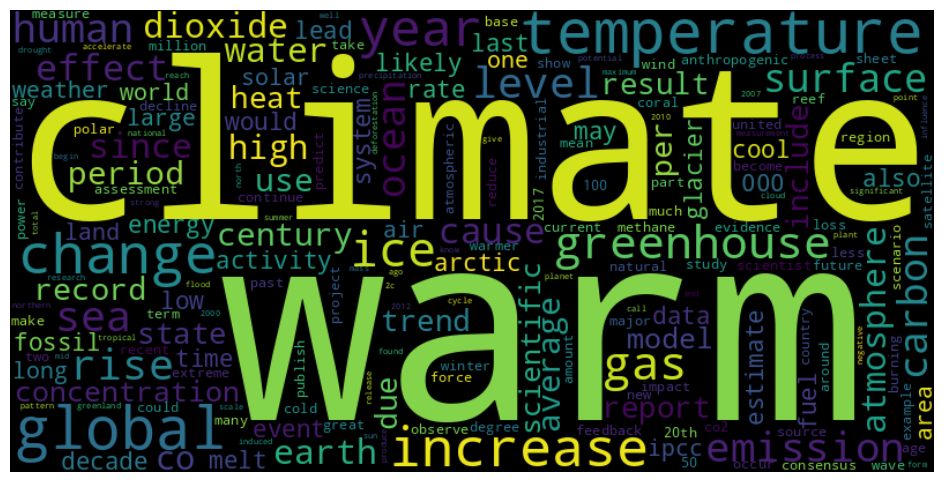

In [40]:
X = vectorizer.fit_transform(claims_df['lemmatize_pos'].apply(' '.join))

# Convert the matrix to a PyTorch tensor
X_tensor = torch.from_numpy(X.toarray())

# Calculate word frequencies
word_freq = torch.sum(X_tensor, dim=0)

# Convert tensor back to numpy array for visualization
word_freq_np = word_freq.numpy()

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame(word_freq_np, index=vectorizer.get_feature_names_out(), columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**result**
- After incopearting the POS-tags in lemmatizaiton, we noticed that have different word cloud as compared without using POS tagging with `warm` being corrected lemmetized

## NER

Named Entity Recognition (NER) is a subtask of information extraction that identifies and classifies named entities in text. It benefits include improving search algorithms, content recommendations, and customer support.

In this section, we will perform (NER) against the `claims_df['lemmatize_pos']` dataframe column review the results, then find ways to optimize

In [41]:
import spacy
from spacy import displacy
import pandas as pd
import matplotlib.pyplot as plt

# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Use the dataframe as input for Named Entity Recognition (NER)
def named_entity_recognition(words):
    text = ' '.join(words)
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]


# Visualize the identified NER ent
def visualize_ner_ent(doc):
    displacy.render(doc, style='ent', jupyter=True)

# Visualize the identified NER dep
def visualize_ner_dep(doc):
    displacy.render(doc, style='dep', jupyter=True)



In [42]:
## Perform NER
claims_df['named_entities_v1'] = claims_df['lemmatize_pos'].apply(named_entity_recognition)

In [43]:
claims_df['named_entities_v1'][9]

[('australia', 'GPE'), ('3.2mm 0.13', 'QUANTITY'), ('20th century', 'DATE')]

In [44]:
# Visualize NER for row 9 ent
visualize_ner_ent(nlp(' '.join(claims_df.loc[9, 'lemmatize_pos'])))

In [45]:
# Visualize NER for row 9 dependancies
visualize_ner_dep(nlp(' '.join(claims_df.loc[9, 'lemmatize_pos'])))

**result**
- On our 1st pass, we noticed that notice that NER did not identify `commonwealth` `csiro` `australia`

After elimianating the obvious issues such as mis-labeling and issues with tokenization we considered the following options

---

- Fine-tuning NER Model: Using domain specifc labeled data, you could fine-tune the existing spaCy NER model to improve its performance on your specific text corpus
- Use of a Larger Model: spaCy provides different models with varying accuracies. You can try using a more accurate model like `en_core_web_md` or `en_core_web_lg`
- Add Custom Entities: If you know in advance some of the entities that the model might not catch, you can add them as custom entities first before the model search

We chose to do #2 & #3 and left #1 for a future exercise

In [ ]:
!python -m spacy download en_core_web_md

In [46]:
!python -m spacy download en_core_web_md en_core_web_sm en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 27.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement en_core_web_lg (from versions: none)
ERROR: No matching distribution found for en_core_web_lg


In [47]:
import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.language import Language
import pandas as pd
import matplotlib.pyplot as plt

# Load a larger spaCy model for better accuracy
nlp = spacy.load('en_core_web_md')

# Register custom_entities function with a decorator
@Language.component("custom_entities")
def custom_entities(doc):
    doc.ents = []
    for i, token in enumerate(doc):
        if token.text == "australia":
            doc.ents += (Span(doc, i, i+1, label="GPE"),)
        if token.text == "commonwealth":
            doc.ents += (Span(doc, i, i+1, label="ORG"),)
        if token.text == "csiro":
            doc.ents += (Span(doc, i, i+1, label="CSIRO"),)
    return doc

# Add custom_entities function to the pipeline
nlp.add_pipe('custom_entities', first='True')


claims_df['named_entities_v2'] = claims_df['lemmatize_pos'].apply(named_entity_recognition)

In [48]:
# Visualize NER for row 9 ent
visualize_ner_ent(nlp(' '.join(claims_df.loc[9, 'lemmatize_pos'])))

In [49]:
claims_df['named_entities_v2'][9]

[('commonwealth', 'ORG'),
 ('csiro', 'CSIRO'),
 ('australia', 'GPE'),
 ('3.2mm 0.13', 'QUANTITY'),
 ('20th century', 'DATE')]

**result**
- By switching to a Use of a Larger Model `en_core_web_md` and use of Custom Entities, we were able to increase the resolution of the exreaction of the Named entities


# Conclusion

The analysis of the dataset provided valuable insights into the text data. The dataset was well-structured, with fields such as `claim_id`, `claim`, `claim_label`, `evidences`, `evidence_id`, `evidence_label`, `article`, `evidence`, `entropy`, and `votes`. For our Natural Language Processing (NLP) tasks, we focused on the `evidence` field.

The initial examination of the text data revealed the presence of punctuations, stop words, ASCII characters, and dates. The most common words were stop words like 'the', 'and', and 'of'. However, after removing these stop words, we were able to focus on more meaningful words in the text.

In terms of tokenization, we noticed that certain tokens like '20th', '0.13in', and '3.2mm' were not captured by the `word_tokenize` function. However, for most NLP tasks, these tokens can be left as is.

We also experimented with stemming and lemmatization to reduce words to their root form. While stemming resulted in some non-meaningful root words, lemmatization was more successful in producing meaningful root words. However, there were still some inaccuracies which we considered improving.

The distribution of Part-of-Speech (POS) tags showed a high occurrence of nouns. Incorporating lemmatization with POS tagging improved our ability to identify the correct lemma of a word.

In terms of Named Entity Recognition (NER), we noticed that certain entities like 'commonwealth', 'csiro', and 'australia' were not identified initially. To improve this, we used a larger model (`en_core_web_md`) and added custom entities. This significantly improved the resolution of named entity extraction.

Our analysis demonstrated the power of NLP techniques in extracting meaningful information from text data. Future work could involve further fine-tuning of the NER model using domain-specific labeled data.

# References

### Datasets
- Diggelmann, T., Boyd-Graber, J., Bulian, J., Ciaramita, M., & Leippold, M. (2020). CLIMATE-FEVER: A Dataset for Verification of Real-World Climate Claims. arXiv preprint arXiv:2012.00614. https://doi.org/10.48550/arXiv.2012.00614

### Youtube Video
 - Text Processing, POS Tagging, Named Entity Recognition - Part 2 | NLP Tutorial | upGrad -> https://youtu.be/MACmU9MxGqE?si=BtZsEDniS9ydEUqY

### Python Packages
- [Contractions](https://github.com/kootenpv/contractions) -> https://github.com/kootenpv/contractions

### Blogs

- https://www.tutorialspoint.com/natural_language_toolkit/natural_language_toolkit_stemming_lemmatization.htm

### Notebooks
- [NLP Preprocessing & Feature Extraction Methods A-Z](https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z) -> https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z


